**LOADING** **THE** **DATASET** **VIA KAGGLE**

In [34]:
!pip install kagglehub[pandas-datasets]

In [35]:
from google.colab import files
files.upload()  # Select kaggle.json when prompted

{}

In [36]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [37]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "googleplaystore_user_reviews.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "lava18/google-play-store-apps",
    file_path,
)

print("First 5 records:", df.head())

/tmp/ipython-input-4199279210.py:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                      App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000  


**Filter for Negative Reviews**

In [38]:
negative_reviews = df[df['Sentiment'] == 'Negative'].copy()
print("Number of negative reviews:", len(negative_reviews))
print(negative_reviews[['Translated_Review', 'Sentiment']].head())

Number of negative reviews: 8271
                                    Translated_Review Sentiment
32                 No recipe book Unable recipe book.  Negative
43  Waste time It needs internet time n ask calls ...  Negative
68                            Faltu plz waste ur time  Negative
85                                  Crap Doesn't work  Negative
95  Boring. I thought actually just texts that's i...  Negative


**Text Preprocessing**

In [39]:
import nltk #NATURAL-LANGUAGE-TOOLKIT
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

#preprocessing to the review text
negative_reviews['cleaned_review'] = negative_reviews['Translated_Review'].apply(preprocess_text)
print(negative_reviews[['Translated_Review', 'cleaned_review']].head())

                                    Translated_Review  \
32                 No recipe book Unable recipe book.   
43  Waste time It needs internet time n ask calls ...   
68                            Faltu plz waste ur time   
85                                  Crap Doesn't work   
95  Boring. I thought actually just texts that's i...   

                                       cleaned_review  
32                     recipe book unable recipe book  
43  waste time needs internet time n ask calls inf...  
68                            faltu plz waste ur time  
85                                   crap doesnt work  
95  boring thought actually texts thats poor old t...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Feature Extraction (TF-IDF Vectorization)**

Term Frequency-Inverse Document Frequency: This approach emphasizes uncommon but significant words in each review, making it easier for clustering algorithms to group similar complaints.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=2500)  # Adjust max feature
X = vectorizer.fit_transform(negative_reviews['cleaned_review'])
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (8271, 2500)


**CLUSTERING**

In [41]:
from sklearn.cluster import KMeans
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)
negative_reviews['cluster'] = clusters
print(negative_reviews[['cleaned_review', 'cluster']].head(15))

                                        cleaned_review  cluster
32                      recipe book unable recipe book        0
43   waste time needs internet time n ask calls inf...        3
68                             faltu plz waste ur time        3
85                                    crap doesnt work        0
95   boring thought actually texts thats poor old t...        0
132                     recipe book unable recipe book        0
143  waste time needs internet time n ask calls inf...        3
168                            faltu plz waste ur time        3
185                                   crap doesnt work        0
195  boring thought actually texts thats poor old t...        0
206                     bad price little bit expensive        0
240                           horrible id verification        0
245                                    nothing missing        0
246  refund takes long days still received money crazy        4
253  trying update every time stall stil

In [42]:
#Top Keywords Per Cluster

In [43]:
import numpy as np
#centroids and feature names
centroids = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Category {i}: ", end="")
    top_indices = centroids[i].argsort()[-10:][::-1]
    print(", ".join(terms[top_indices]))

Category 0: bad, hate, worst, app, slow, useless, sucks, like, fake, ever
Category 1: game, play, like, fun, playing, get, level, love, time, money
Category 2: ads, game, annoying, ad, many, play, every, get, hate, really
Category 3: waste, time, dont, app, total, money, data, work, useless, worst
Category 4: get, cant, time, even, update, phone, im, fix, please, back


In [44]:
# Group by cluster and display a few reviews per group
for c in range(num_clusters):
    print(f"\n=== Cluster {c} ===")
    sample = negative_reviews[negative_reviews['cluster'] == c]['Translated_Review'].head(5)
    for review in sample:
        print("-", review)


=== Cluster 0 ===
- No recipe book Unable recipe book.
- Crap Doesn't work
- Boring. I thought actually just texts that's it. Too poor old texts....
- No recipe book Unable recipe book.
- Crap Doesn't work

=== Cluster 1 ===
- I like game
- I play game
- It's toooo gud game
- Mind uses game
- Simple game pass time away. My grandson like it.

=== Cluster 2 ===
- Terrible amount ads covering content making unpleasant play. Avoid
- I loved ads starting popping using it. Get rid ads dominating entire screen. I hate that. At least put ads corners make small really hinder well I app.
- Id love wasn't ads. I mean allows adult ads on kids flip'n ridiculous.
- The many ads, episodes free. I seriously disappointed app!
- The audio adds annoying. I can't read news without ads blaring . Scares beginners anyone sitting around me.

=== Cluster 3 ===
- Waste time It needs internet time n ask calls information
- Faltu plz waste ur time
- Waste time It needs internet time n ask calls information
- Fal

In [45]:
negative_reviews.to_csv("negativereviewsclustered.csv", index=False)

**VISUALIZATION**

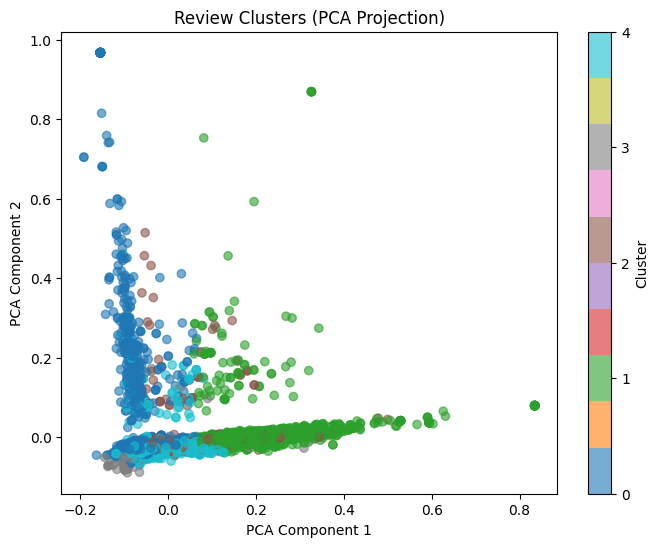

In [46]:
#2D visualization using PCA (Principle Component Analysis)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=negative_reviews['cluster'], cmap='tab10', alpha=0.6)
plt.title('Review Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, ticks=range(negative_reviews['cluster'].nunique()), label='Cluster')
plt.show()


/tmp/ipython-input-1219541014.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab10')


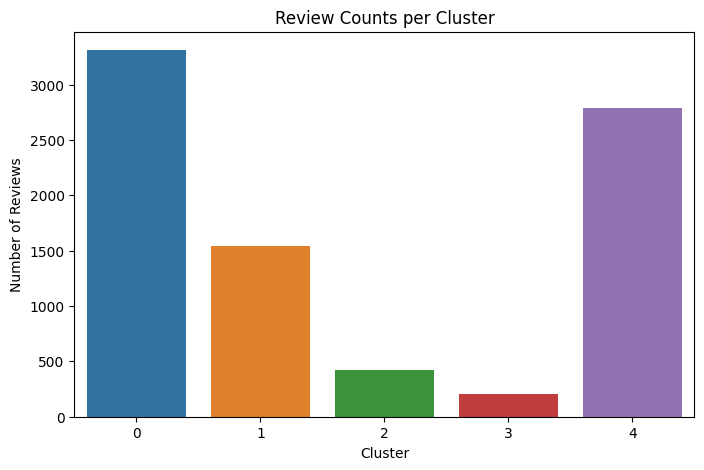

In [47]:
#Review Counts per Category
import seaborn as sns
cluster_counts = negative_reviews['cluster'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab10')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.title('Review Counts per Cluster')
plt.show()

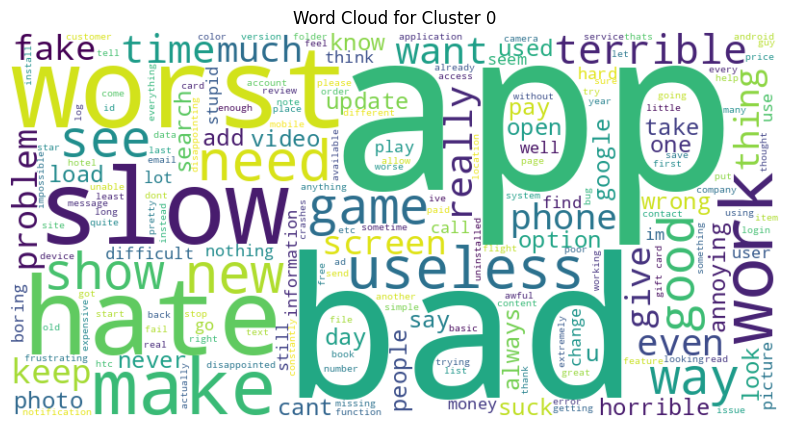

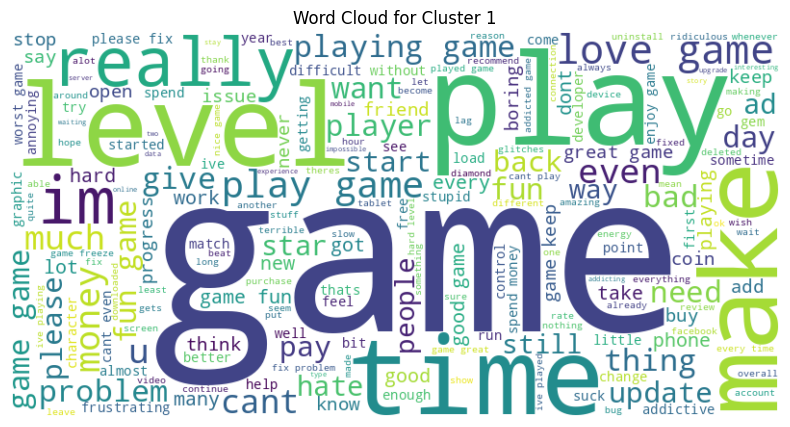

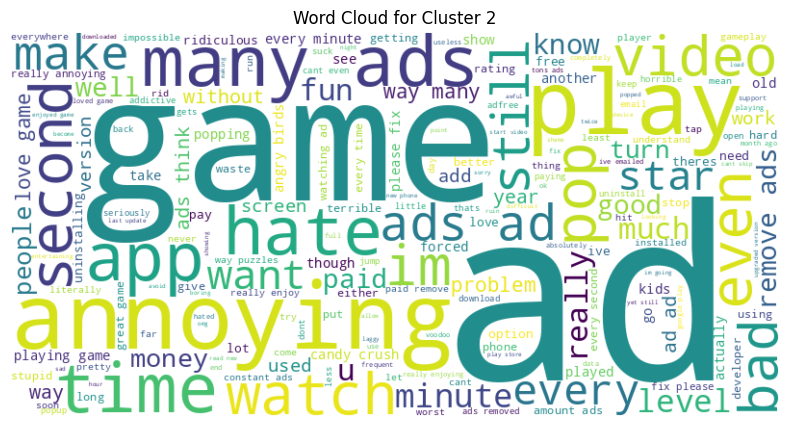

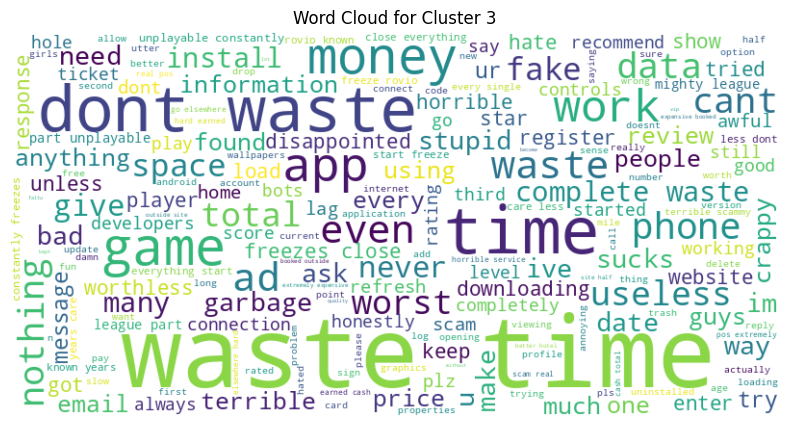

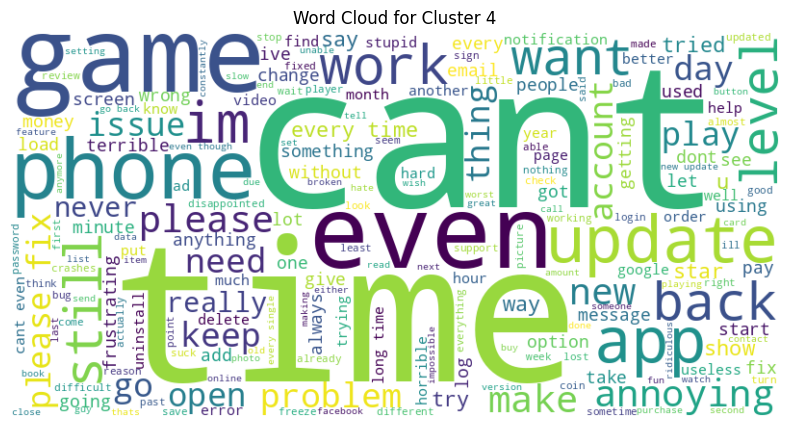

In [48]:
#Word Cloud
from wordcloud import WordCloud
terms = vectorizer.get_feature_names_out()

for cluster_num in sorted(negative_reviews['cluster'].unique()):
    cluster_text = " ".join(negative_reviews[negative_reviews['cluster'] == cluster_num]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


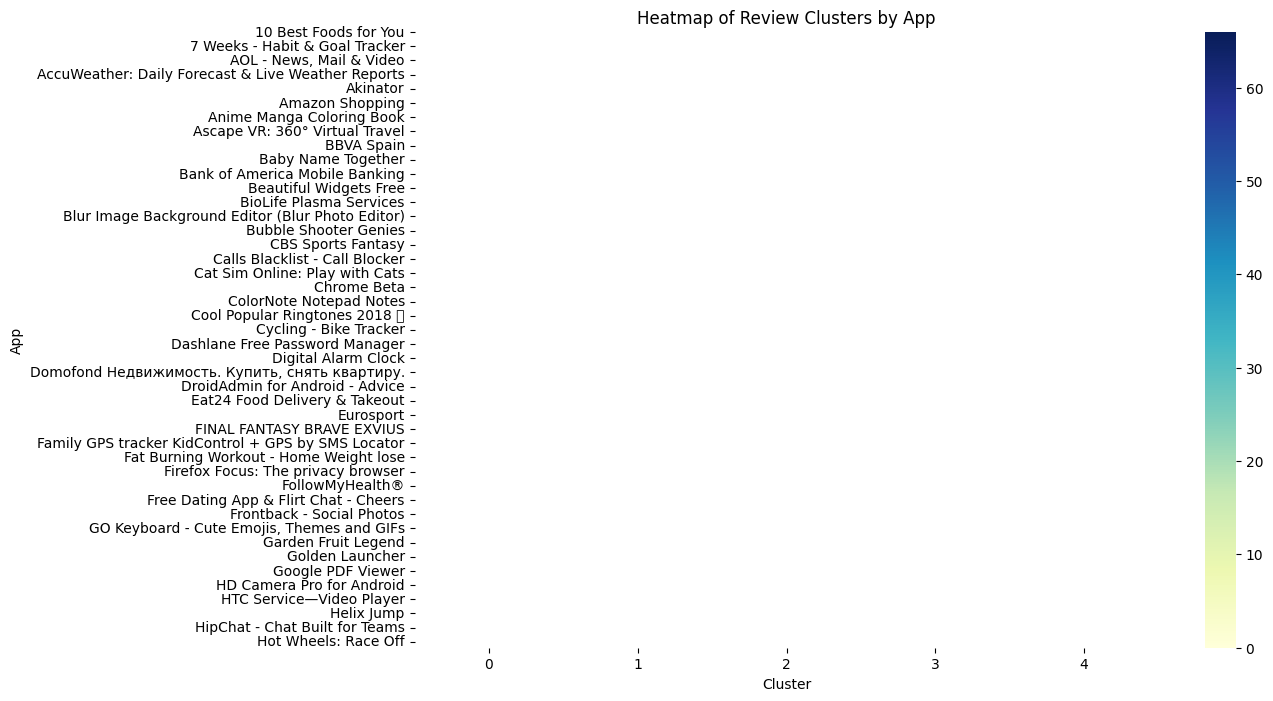

In [49]:
# Heatmap
heatmap_data = negative_reviews.pivot_table(
    index='App',
    columns='cluster',
    aggfunc='size',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Review Clusters by App')
plt.xlabel('Cluster')
plt.ylabel('App')
plt.show()

# Summary of Google Play Store Negative Reviews Analysis

We analyzed a large set of negative user reviews from Google Play Store apps to uncover the main types of problems users face. By using advanced text processing and machine learning techniques, we grouped similar complaints together. This can help app developers identify key issues and prioritize improvements effectively.

### What We Did:

1. **Focused on Negative Reviews:** We filtered out all negative feedback to understand where users face difficulties or dissatisfaction.

2. **Cleaned the Text:** The review texts were simplified by removing filler words, punctuation, and common words that don't add meaning, making our analysis clearer.

3. **Converted Text to Numbers:** Using a technique called TF-IDF, we turned words into numbers that capture their importance in each review.

4. **Grouped Reviews by Theme:** We used a clustering algorithm that automatically grouped reviews sharing similar complaints or topics.

5. **Interpreted Clusters:** For each group, we identified the most frequently used words to describe the common problem. For example, clusters revealed issues like login failures, app crashes, excessive ads, performance problems, and data loss.

6. **Sampled Reviews:** We looked at example reviews from each cluster to confirm that the groupings made sense.

7. **Visualized Insights:**
   - We created easy-to-understand visual charts that show how the reviews cluster together.
   - We made word clouds to highlight key terms users often mention in each complaint category.
   - We also created heatmaps to show which apps have the most issues in each complaint group.